<a href="https://colab.research.google.com/github/BaharehYekkehkhany/Sea-wind-speed-and-direction-estimation-using-SAR/blob/main/test_WSPD_211104.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## install the last version of scikit-learn
!pip install -U scikit-learn
## show the version of installed scikit-learn
!python -m pip show scikit-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Name: scikit-learn
Version: 1.0.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, scipy, joblib, threadpoolctl
Required-by: yellowbrick, sklearn, sklearn-pandas, mlxtend, lightgbm, librosa, imbalanced-learn, fastai


In [ ]:
## panda: load and store dataframe structures (tabular data)
import pandas as pd
## numpy: a numerical python library; to work with multi-dimentional arrays and mtrices
import numpy as np
## matplotlib: 2D and 3D plotting
import matplotlib.pyplot as plt
## sklearn: machine learning methods
## sklearn.linear_model.LinearRegression: provides linear regression function
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Lasso, LassoCV, Ridge
from sklearn.metrics import explained_variance_score, max_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, normalize
## Msklearn.neural_network.MLPRegressor: multi-layer Perceptron regressor
## This model optimizes the squared-loss using LBFGS or stochastic gradient descent.
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
## to load .mat files
from scipy.io import loadmat
from numpy import arange
import cmath
# ## to use HDF reader for matlab v7.3 files
# import h5py
import scipy
import scipy.io as spio
import math
## This snippet uses the open-source gspread library for interacting with Sheets.
import gspread

## https://www.youtube.com/watch?v=maiQf8ray_s
from scipy.stats import zscore
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

import tensorflow as tf

## to use epsilon
import sys
## to find the best hyperparameters of a model based on cross-validation method
## first, install the last version of scikit-learn
## !pip install -U scikit-learn
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint

##------------------------------------------------------------------------------
## change directory to google drive to read input and output data

from google.colab import drive
drive.mount('/content/drive')


##------------------------------------------------------------------------------
## import data

## This function is a modified version of scipy.io.loadmat to read nested structures saved as .mat
## MATLAB reference: https://ch.mathworks.com/matlabcentral/answers/383427-proper-importing-of-matlab-structures-into-python
## Stack Overflow reference: https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
def load_mat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)


def import_data(inputs_address, outputs_address):

  """
## import dataset: reading RS2 and Buoy data as well as parameters extracted
## from RS2 full-polarimetric data

## inputs
## inputs: a structure that contains all parameters as predictor variables
## Here, parameters are mean parameters of the whole image chip
## inputs structure includes parameters extracted from image chip sizes of
## 512*512 while buoys are at the center of the images.

## outputs: a structure that contains wind speed and wind direction that are
## the values that are to be estimated.
## wind speed and wind direction values are based on the buoy measurements.
## Here, wind speeds are at the height of 10 meters above the sea surface.
## Buoy measurements are transferred to the height of 10 m by LKB algorithm.
## Here, wind directions are relative wind directions with regard to
## incident azimuth angle that is calculated as
## relative_wdir(i) = mod((heading(i) - wdir(i)), 360);
## heading is the incident azimuth angle and wdir is buoy measurement

## output
## inputs: a panda.DataFrame that includes all inputs
## outputs: a panda.DataFrame that includes all outputs

  """

  # inputs = load_mat(r"E:\\Codes\PolSAR_features_Python\New folder\inputs.mat")['inputs']
  # inputs = load_mat('/content/drive/My Drive/Colab Notebooks/inputs.mat')['inputs']
  inputs = load_mat(inputs_address)['inputs']
  inputs = inputs['inputs']

  inputs = pd.DataFrame.from_dict(inputs)
  ## to replace +/- inf values with nan
  inputs.replace([np.inf, -np.inf], np.nan, inplace=True)
  # print(inputs.isna().sum())
  # ## replace nan values with 0
  # inputs.fillna(0, inplace=True)

  # outputs = load_mat(r"E:\\Codes\PolSAR_features_Python\New folder\outputs.mat")['outputs']
  # outputs = load_mat('/content/drive/My Drive/Colab Notebooks/outputs.mat')['outputs']
  outputs = load_mat(outputs_address)['outputs']
  outputs = outputs['outputs']

  outputs = pd.DataFrame.from_dict(outputs)
  ## replace +/- inf values with nan
  outputs.replace([np.inf, -np.inf], np.nan, inplace=True)
  # print(outputs.isna().sum())
  # ## replace nan values with 0
  # outputs.fillna(0, inplace=True)

  ## remove invalid data
  input_nan_index = inputs.index[inputs.isnull().any(1)].tolist()
  output_nan_index = outputs.index[outputs.isnull().any(1)].tolist()
  inputs.drop(input_nan_index + output_nan_index, inplace=True)
  outputs.drop(input_nan_index + output_nan_index, inplace=True)

  return inputs, outputs


##------------------------------------------------------------------------------
## predictor variable scaling
def predictor_scaling(inputs, scaling_model):
  if scaling_model == "standardization":
    inputs_scaled = (inputs - inputs.mean())/(inputs.std() + sys.float_info.epsilon)
  elif scaling_model == "normalization":
    inputs_scaled = (inputs - inputs.min())/(inputs.max() - inputs.min() + sys.float_info.epsilon)

  return inputs_scaled


##------------------------------------------------------------------------------
## predictor variable selection
def predictor_selection(inputs, outputs, alpha, selection_criteria, model_name):

  # https://www.geeksforgeeks.org/implementation-of-lasso-ridge-and-elastic-net/
  # Elasticnet
  if model_name.lower() in ['lasso']:
    # Lasso(alpha=1.0, *, fit_intercept=True, normalize=True,\
    #     precompute=False, copy_X=True, max_iter=1000, tol=0.0001, \
    #     warm_start=False, positive=False, random_state=None, selection='cyclic')
    model = Lasso(alpha=alpha)
    # model.fit(inputs.values.real, outputs)
    model.fit(inputs.astype(np.float64), outputs)
    # selected_columns = abs(model.coef_) > selection_criteria
    selected_columns = abs(model.coef_) > 0.0001
    if np.any(selected_columns):
      selected_inputs = inputs.loc[:, selected_columns]
    else:
      selected_columns = abs(model.coef_) == max(abs(model.coef_))
      selected_inputs = inputs.loc[:, selected_columns]
    print('\n selected input features')
    print(selected_inputs.keys())
    # print('\n input coefficients after feature selection:')
    # print(model.coef_)
  elif model_name.lower() in ['ridge']:
    ## Ridge(alpha=1.0, *, fit_intercept=True, normalize=False, copy_X=True, \
    ##  max_iter=None, tol=0.001, solver='auto', random_state=None)
    model = Ridge(alpha=alpha)
    model.fit(inputs.values, outputs)
    selected_columns = abs(model.coef_) > selection_criteria
    if np.any(selected_columns):
      selected_inputs = inputs.loc[:, selected_columns]
    else:
      selected_columns = abs(model.coef_) == max(abs(model.coef_))
      # print(selected_columns)
      selected_inputs = inputs.loc[:, selected_columns]
    print('\n selected input features')
    print(selected_inputs.keys())
    # print('\n input coefficients after feature selection:')
    # print(model.coef_)

  elif model_name.lower() in ['correlation']:
    ## correlation coefficient between the relative wind direction and
    ## Radarsat-2 polarimetric features
    corre_coefs = []
    # cc = []
    corrs = []
    for field in inputs.keys():
      corre_coef = np.corrcoef(np.transpose(inputs[field]).astype(float), \
              np.transpose(outputs.values).astype(float))
      corre_coefs.append([corre_coef[0, 1]])
      corrs.append([field, corre_coef[0, 1]])
    print('correlation coefficient between the wind speeds and '
          'Radarsat-2 polarimetric features: ')
    print(corrs)
    # print(corre_coefs)
    # print(inputs.keys())
    # cc = pd.DataFrame(np.transpose(corre_coefs), columns=inputs.keys(), index=None)
    # print('correlation coefficient between the relative wind directions and '
    #       'Radarsat-2 polarimetric features: ')
    # print(cc)
    selected_columns = cc.abs() > selection_criteria
    if np.any(selected_columns.values):
      selected_inputs = inputs.loc[:, selected_columns.values.transpose()]
    else:
      selected_columns = abs(cc.values) == max(abs(cc.values))
      selected_inputs = inputs.loc[:, selected_columns.values.transpose()]
    print('\n selected input features')
    print(selected_inputs.keys())
    print('\n selected input correlation coefficients with wind speed:')
    print(cc.loc[:, selected_columns.values.transpose()])

  ## plot selected features vs Buoy WDIR
  for key in selected_inputs.keys():
    plt.scatter(outputs.values, selected_inputs[key])
    plt.xlabel("Buoy WSPD")
    plt.ylabel(key)
    plt.show()

  return selected_inputs


##------------------------------------------------------------------------------
## test and training data selection
def test_train_selection(inputs, outputs):

  """
  ## regression process for data with various incidence angles
  ## the iteration is done from minimum to maximum values of incidence angles with the step size of theta_step

  ## input:
  ## inputs: the DataFrame that includes all inputsfor the estimation process
  ## outputs: the DataFrame that includes wind speed

  ## find a relation between data parameters and wind speed for each theta bin
  ## the iteration is done from minimum to maximum values of incidence angles with the step size of theta_step

  ## output:
  """

  ## set x (inputs): all predictor variables
  ## set y (output): here it is wind speed
  y = np.floor(outputs)
  x = inputs
  # x = inputs.abs()


  ## make all input values real values
  x = x.values.real

  ## split the data to train and test data
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)
  # print(x_train.shape)
  # print(y_train.head())
  # print(x_test.shape)
  # print(y_test.head())

  return x_train, x_test, y_train, y_test


##------------------------------------------------------------------------------
## regression models
##------------------------------------------------------------------------------
## linear and polynomial regressions
def polynomial_regression(x_train, x_test, y_train, y_test, least_error):

## linear and polynomial regressions
##  start from degree 2 and increase it to degree 10 to evaluate the model predictions using the test data

## input:
## x_train, y_train: train data
## x_test, y_test: test data
## least_error: the first estimate of the least error; it does not have any effect on the error estimation.
## The leas_error value for wind direction estimation should be far more than its value for wind speed estimation.
## the suggestion for least_error for wind speed estimation: 10
## the suggestion for least_error for wind direction estimation: 100000

## output:
##least_error: the error of fitting the best fitted polynomial to the test data
## best_match_degree: the degree of the best polynomial that fits the data
## best_model_intercept:
## best_model_coef: the coefficients of the best fitted polynomial

  for degree in range(1, 11):
      polynomial_features = PolynomialFeatures(degree)
      x_poly = polynomial_features.fit_transform(x_train)

      model = LinearRegression(fit_intercept=True, normalize=True)

      ## fit model on training data
      model.fit(x_poly, y_train)

      ## prediction on train data
      y_train_predict = model.predict(x_poly)

      ## prediction on  test data
      y_test_predict = model.predict(polynomial_features.fit_transform(x_test))

      ## evaluation metric for test data
      error_test = np.sqrt(mean_squared_error(y_test, y_test_predict))

      # print(error_test)
      if error_test < least_error:
          least_error = error_test
          best_match_degree = degree
          best_model_intercept = model.intercept_
          best_model_coef = model.coef_
  print("The best wind speed model to fit the dataset is "
        "a polynomial of degree {}. \n".format(best_match_degree))
  # print("The best wind speed model to fit the dataset is "
  #       "a polynomial of degree {} with an error of {:.2f} m/s with {}, {}, and {} number of samples, "
  #       "train data, and test data, respectively. \n".format(\
  #        best_match_degree, least_error, len(inputs), \
  #        len(x_train), len(x_test)))

  return y_test_predict, y_train_predict


##------------------------------------------------------------------------------
## MLP regression
def mlp_regression(input, output, activation, solver, max_iter, k_fold):

## neural network multi-layer Perceptron (NN-MLP) regressor
## This model optimizes the squared-loss using LBFGS or stochastic gradient descent.
## rvaluate the model predictions using the test data

## input:
## x_train, y_train: train data
## x_test, y_test: test data
## max_iter: maximum iteration of the MLP regressor

## output:
  # model = MLPRegressor(max_iter, batch_size=min(batch_size, x_train.shape[0]), \
  #                       random_state=1)

  print('\n ***** neural network *****')

  x = input.values.astype(float)
  y = output.values.astype(float)

  ## sample size
  n_of_samples = np.shape(input)[0]
  ## check that sample size is larger than the split size
  if (n_of_samples > k_fold):

    ## cross validation iterators
    # ## K-fold
    # # from sklearn.model_selection import KFold
    # shuffle = True
    # random_state = 42
    # kf = KFold(n_splits=k_fold, shuffle=shuffle, random_state=random_state)
    # cvi = kf
    # file_NN_results.writerow(['k-fold is used.'])
    # file_NN_results.writerow(['k_fold'] + [k_fold])
    # file_NN_results.writerow(['shuffle'] + [shuffle])
    # file_NN_results.writerow(['random state'] + [random_state])
    ## repeated K-fold
    from sklearn.model_selection import RepeatedKFold
    n_repeats = 3
    random_state = 42
    rkf = RepeatedKFold(n_splits=k_fold, n_repeats=n_repeats, \
                        random_state=random_state)
    cvi = rkf
    # file_NN_results.writerow(['repeated k-fold is used.'])
    # file_NN_results.writerow(['k_fold'] + [k_fold])
    # file_NN_results.writerow(['number of repeats'] + [n_repeats])
    # file_NN_results.writerow(['random state'] + [random_state])
    ## leave one out
    # from sklearn.model_selection import LeaveOneOut
    # loo = LeaveOneOut()
    # cvi = loo
    # file_NN_results.writerow(['leave-one-out is used.'])
    ## leave P out
    # from sklearn.model_selection import LeavePOut
    # p = 2
    # lpo = LeavePOut(p=p)
    # cvi = lpo
    # file_NN_results.writerow(['leave-p-out is used.'])
    # file_NN_results.writerow(['p'] + [p])
    ## Random permutations cross-validation a.k.a. Shuffle & Split
    # from sklearn.model_selection import ShuffleSplit
    # test_size = 0.2
    # random_state = 1
    # ss = ShuffleSplit(n_splits=k_fold, test_size=test_size, \
    #                   random_state=random_state)
    # cvi = ss
    # file_NN_results.writerow(['Random permutations cross-validation a.k.a. Shuffle & Split is used.'])
    # file_NN_results.writerow(['k_fold'] + [k_fold])
    # file_NN_results.writerow(['test size'] + [test_size])
    # file_NN_results.writerow(['random state'] + [random_state])

    oos_y = []
    oos_pred = []

    rmse_all = []
    r2_all = []
    cc_all = []
    mae_all = []

    rmse = 360
    fold = 0
    for train, test in cvi.split(x):
      fold+=1
      print(f"Fold #{fold}")
      # file_NN_results.writerow(['fold number'] + [fold])

      x_train = x[train]
      y_train = y[train]
      x_test = x[test]
      y_test = y[test]

      model = Sequential()
      model.add(Dense(60, input_dim=x.shape[1], activation=activation))
      model.add(Dense(30, activation=activation))
      model.add(Dense(1))

      model.compile(loss='mae', optimizer=solver, \
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])

      # ##show a summary of the model
      # model.summary()

      ## fit model
      history = model.fit(x_train, y_train, validation_data=(x_test, y_test), \
                          verbose=0, epochs=max_iter)

      ## evaluate the model: rmse
      _, train_acc = model.evaluate(x_train, y_train, verbose=0)
      _, test_acc = model.evaluate(x_test, y_test, verbose=0)
      # print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

      # # list all data in history
      # print('All data in history:')
      # print(history.history.keys())

      # ## plot loss during training
      # plt.subplot(211)
      # plt.title('Loss')
      # plt.plot(history.history['loss'], label='train')
      # plt.plot(history.history['val_loss'], label='test')
      # plt.legend()
      # print("\n \n")
      # ## plot accuracy during training
      # plt.subplot(212)
      # plt.title('root_mean_squared_error')
      # plt.plot(history.history['root_mean_squared_error'], label='train')
      # plt.plot(history.history['val_root_mean_squared_error'], label='test')
      # plt.legend()
      # plt.show()

      pred = model.predict(x_test)

      ## out of sample: oos
      oos_y.append(y_test)
      oos_pred.append(pred)

      cc = np.corrcoef(np.transpose(pred), np.transpose(y_test))
      score = cc[0, 1]
      limit = 0; # for cc
      # print(f"Fold rmse (test): {score}")

      ## save all rmse, r^2, cc, and mae of all folds for further statistical results
      rmse_all.append(np.sqrt(metrics.mean_squared_error(pred, y_test)))
      r2_all.append(r2_score(y_test, pred))
      cc = np.corrcoef(np.transpose(pred), np.transpose(y_test))
      cc_all.append(cc[0, 1])
      mae_all.append(mean_absolute_error(y_test, pred))

      ## find the best model and predict the output (WDIR) for all the input data
      ## with the best model
      # if score < limit: # for rmse
      if score > limit: # for cc
        rmse = np.sqrt(metrics.mean_squared_error(pred, y_test))
        output_predict = model.predict(x)
        best_x_train = x_train
        best_y_train = y_train
        best_x_test = x_test
        best_y_test = y_test

        best_rmse = test_acc
        best_r2 = r2_score(y_test, pred)
        cc = np.corrcoef(np.transpose(pred), np.transpose(y_test))
        best_cc = cc[0, 1]
        best_mae = mean_absolute_error(y_test, pred)

        best_fold = fold

        best_model = model

    ## plot Buoy WDIR data vs WDIR predicted data
    plt.title('NN regression')
    plt.scatter(best_model.predict(best_x_train), best_y_train, label='train')
    plt.scatter(best_model.predict(best_x_test), best_y_test, label='test')
    plt.xlabel("predicted WSPD by the best MLP model")
    plt.ylabel("Buoy WSPD")
    plt.legend()
    plt.show()
    ## Show the statistics for the best fold
    print(f"\n \nBest fold number: {best_fold}")
    print(f"Best model rmse: {best_rmse:5.3f}")
    print(f"Best model r2: {best_r2:5.3f}")
    print(f"Best model cc: {best_cc:5.3f}")
    print(f"Best model mae: {best_mae:5.3f}")

    ## box plots of rmse, r^2, cc, and mas for all folds
    print('statistics')
    statistics = pd.DataFrame(rmse_all, columns=['RMSE'])
    boxplot = statistics.boxplot()
    plt.show()
    statistics = pd.DataFrame(r2_all, columns=['R^2'])
    boxplot = statistics.boxplot()
    plt.show()
    statistics = pd.DataFrame(cc_all, columns=['CC'])
    boxplot = statistics.boxplot()
    plt.show()
    statistics = pd.DataFrame(mae_all, columns=['MAE'])
    boxplot = statistics.boxplot()
    plt.show()

    ## build the oos prediction list and calculate error
    oos_y = np.concatenate(oos_y)
    oos_pred = np.concatenate(oos_pred)
    score = np.sqrt(metrics.mean_squared_error(oos_pred, oos_y))
    # print(f"\n Final, out of sample rmse: {score}")
    # print(f"Final, out of sample r2: {r2_score(oos_y, oos_pred)}")
    # corre_coef = np.corrcoef(np.transpose(oos_pred), \
    #             np.transpose(oos_y))
    # print(f"Final, out of sample correlation coefficient: {corre_coef[0, 1]}")
    # print(f"Final, out of sample mean absolute error: {mean_absolute_error(oos_y, oos_pred)}")
    # print(f"Final, out of sample maximum residual error: {max_error(oos_y, oos_pred)}")

    ## write the cross validation prediction
    oos_y = pd.DataFrame(oos_y)
    oos_pred = pd.DataFrame(oos_pred)
    oosDF = pd.concat([oos_y, oos_pred], axis=1)
    # oosDF.to_csv(filename_write, index=False)

    # ## plot feature importance based on feature permutation
    # ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    # feature_names = input.keys()
    # from sklearn.inspection import permutation_importance
    # result = permutation_importance(best_model, best_x_test, best_y_test, \
    #     n_repeats=10, random_state=42, n_jobs=2)
    # forest_importances = pd.DataFrame({'importances':result.importances_mean, \
    #     'std':result.importances_std}, index=feature_names)
    # ## sort features based on their importance
    # forest_importances.sort_values(by=['importances'], ascending=False, \
    #                                inplace=True)
    # fig, ax = plt.subplots()
    # forest_importances[\
    #     'importances'][0:10].plot.bar(yerr=forest_importances['std'][0:10], ax=ax)
    # ax.set_title("Feature importances using permutation on full model")
    # ax.set_ylabel("Mean accuracy decrease")
    # fig.tight_layout()
    # plt.show()

  else:
    output_predict = np.empty([0,0])
    print('\n NN: Sample size is less than number of splits!')

  return output_predict


##------------------------------------------------------------------------------
## remove invalid data with negative values of wind speed
def remove_invalid_predicted_values(y_test_predict, \
  y_test, y_train_predict, y_train):
  y_test_predict = pd.DataFrame(data=y_test_predict, columns=['wspd_10ht'])
  y_test_predict.reset_index(drop=True, inplace=True)
  y_test.reset_index(drop=True, inplace=True)
  invalid_indexes = y_test_predict['wspd_10ht'] < 0

  y_test_predict.drop(y_test_predict[invalid_indexes].index, inplace=True)
  y_test.drop(y_test[invalid_indexes].index, inplace=True)

  y_train_predict = pd.DataFrame(data=y_train_predict, columns=['wspd_10ht'])
  y_train_predict.reset_index(drop=True, inplace=True)
  y_train.reset_index(drop=True, inplace=True)
  invalid_indexes = y_train_predict['wspd_10ht'] < 0

  y_train_predict.drop(y_train_predict[invalid_indexes].index, inplace=True)
  y_train.drop(y_train[invalid_indexes].index, inplace=True)

  return y_test_predict, y_test, y_train_predict, y_train


##------------------------------------------------------------------------------
## Random forest (RF) regression
def random_forest_regression(input, output, k_fold):

  ## input:
  ## input: all parameters extracted from pol-SAR data as predictors
  ## output: the target which is the NDVI values based on RapiEye observations
  ## k_fold: number of subsections defined in cross validation

  ## output:
  ## output_predict: predicted NDVI values

  print('\n ***** random forest *****')

  x = input.values.astype(float)
  y = output.values.astype(float)

  ## sample size
  n_of_samples = np.shape(input)[0]
  ## check that sample size is larger than the min_resources_=10
  ## to avoid this error: min_resources_=10 is greater than max_resources_=(# of samples)
  if (n_of_samples < 11):
    output_predict = np.empty([0,0])
    print('\n RF: Sample size is less than number of splits!')
    ## I changed k_fold here so that it does not go to the other if and avoid
    ## this error: min_resources_=10 is greater than max_resources_=(# of samples)
    k_fold = 1000

  ## check that sample size is larger than the split size
  if (n_of_samples > k_fold):
    ## cross validation iterators
    # ## K-fold
    # from sklearn.model_selection import KFold
    # kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
    # cvi = kf
    ## repeated K-fold
    from sklearn.model_selection import RepeatedKFold
    rkf = RepeatedKFold(n_splits=k_fold, n_repeats=3, random_state=42)
    cvi = rkf
    ## leave one out
    # from sklearn.model_selection import LeaveOneOut
    # loo = LeaveOneOut()
    # cvi = loo
    ## leave P out
    # from sklearn.model_selection import LeavePOut
    # lpo = LeavePOut(p=2)
    # cvi = lpo
    ## Random permutations cross-validation a.k.a. Shuffle & Split
    # from sklearn.model_selection import ShuffleSplit
    # ss = ShuffleSplit(n_splits=k_fold, test_size=0.2, random_state=1)
    # cvi = ss


    oos_y = []
    oos_pred = []

    rmse_all = []
    r2_all = []
    cc_all = []
    mae_all = []

    rmse = 360
    fold = 0
    for train, test in cvi.split(x):
      fold+=1
      print(f"\n Fold #{fold}")

      x_train = x[train]
      y_train = y[train]
      x_test = x[test]
      y_test = y[test]

      # define the model
      # RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
      # model = RandomForestRegressor(n_estimators=100) # n_estimators=150
      rf = RandomForestRegressor(criterion='squared_error')
      param_distributions = {"n_estimators": randint(10, 150),
                             "max_depth": [1, 3, 5,None],
                             "min_samples_split": randint(2, 11),
                             "min_samples_leaf": randint(1, 10),
                             "bootstrap": [True, False]
                             }
      search = HalvingRandomSearchCV(rf, param_distributions,
               random_state=0).fit(x_train, y_train.ravel())
      # search = HalvingRandomSearchCV(model, param_distributions,
      #          resource='n_estimators',max_resources=10,
      #          random_state=0).fit(x_train, y_train.ravel())

      # print('best model parameter: ')
      # print(search.best_params_)

      model = search.best_estimator_
      model.fit(x_train, y_train.ravel())

      pred = model.predict(x_test)

      ## out of sample: oos
      oos_y.append(y_test)
      oos_pred.append(pred)

      ## measure this fold's rmse
      # pred_train = model.predict(x_train)
      # score = np.sqrt(metrics.mean_squared_error(pred_train, y_train))
      # print(f"Fold rmse (train): {score}")
      # score = np.sqrt(metrics.mean_squared_error(pred, y_test))
      # limit = 10; # for rmse
      cc = np.corrcoef(np.transpose(pred), np.transpose(y_test))
      score = cc[0, 1]
      limit = 0; # for cc
      # print(f"Fold rmse (test): {score}")

      ## save all rmse, r^2, cc, and mae of all folds for further statistical results
      rmse_all.append(np.sqrt(metrics.mean_squared_error(pred, y_test)))
      r2_all.append(r2_score(y_test, pred))
      cc = np.corrcoef(np.transpose(pred), np.transpose(y_test))
      cc_all.append(cc[0, 1])
      mae_all.append(mean_absolute_error(y_test, pred))

      ## find the best model and predict the output (WDIR) for all the input data
      ## with the best model
      # if score < limit: # for rmse
      if score > limit: # for cc
        rmse = np.sqrt(metrics.mean_squared_error(pred, y_test))
        output_predict = model.predict(x)
        best_x_train = x_train
        best_y_train = y_train
        best_x_test = x_test
        best_y_test = y_test

        best_rmse = np.sqrt(metrics.mean_squared_error(pred, y_test))
        best_r2 = r2_score(y_test, pred)
        cc = np.corrcoef(np.transpose(pred), np.transpose(y_test))
        best_cc = cc[0, 1]
        best_mae = mean_absolute_error(y_test, pred)

        best_fold = fold

        best_model = model

        best_model_parameters = search.best_params_




      # ## plot Buoy WDIR data vs WDIR predicted data
      # plt.title('RF regression')
      # plt.scatter(model.predict(x_train), y_train, label='train')
      # plt.scatter(model.predict(x_test), y_test, label='test')
      # plt.xlabel("predicted WSPD by the best RF model")
      # plt.ylabel("Buoy WSPD")
      # plt.legend()
      # plt.show()
      # from scipy.io import savemat
      # filename_pred_rf = "/content/drive/My Drive/Colab Notebooks/Wind_estimation/WSPD/WSPD_predicted_rf_" + str(fold) + ".mat"
      # output_predict_dict = {"output_predict_mlp": model.predict(input.values.astype(float))}
      # savemat(filename_pred_rf, output_predict_dict)







    ## plot Buoy WDIR data vs WDIR predicted data
    plt.title('RF regression')
    plt.scatter(best_model.predict(best_x_train), best_y_train, label='train')
    plt.scatter(best_model.predict(best_x_test), best_y_test, label='test')
    plt.xlabel("predicted WSPD by the best RF model")
    plt.ylabel("Buoy WSPD")
    plt.legend()
    plt.show()

    ## Show the statistics for the best fold
    print(f"\n \nBest fold number: {best_fold}")
    print(f"Best model rmse: {best_rmse:5.3f}")
    print(f"Best model r2: {best_r2:5.3f}")
    print(f"Best model cc: {best_cc:5.3f}")
    print(f"Best model mae: {best_mae:5.3f}")
    print(f"Best model parameters: {best_model_parameters}")

    ## box plots of rmse, r^2, cc, and mas for all folds
    print('statistics')
    statistics = pd.DataFrame(rmse_all, columns=['RMSE'])
    boxplot = statistics.boxplot()
    plt.show()
    statistics = pd.DataFrame(r2_all, columns=['R^2'])
    boxplot = statistics.boxplot()
    plt.show()
    statistics = pd.DataFrame(cc_all, columns=['CC'])
    boxplot = statistics.boxplot()
    plt.show()
    statistics = pd.DataFrame(mae_all, columns=['MAE'])
    boxplot = statistics.boxplot()
    plt.show()

    ## build the oos prediction list and calculate error
    oos_y = np.concatenate(oos_y)
    oos_pred = np.concatenate(oos_pred)
    score = np.sqrt(metrics.mean_squared_error(oos_pred, oos_y))
    # print(f"\n Final, out of sample rmse: {score}")
    # print(f"Final, out of sample r2: {r2_score(oos_y, oos_pred)}")
    # corre_coef = np.corrcoef(np.transpose(oos_pred), \
    #             np.transpose(oos_y))
    # print(f"Final, out of sample correlation coefficient: {corre_coef[0, 1]}")
    # print(f"Final, out of sample mean absolute error: {mean_absolute_error(oos_y, oos_pred)}")
    # print(f"Final, out of sample maximum residual error: {max_error(oos_y, oos_pred)}")

    ## write the cross validation prediction
    oos_y = pd.DataFrame(oos_y)
    oos_pred = pd.DataFrame(oos_pred)
    oosDF = pd.concat([oos_y, oos_pred], axis=1)
    # oosDF.to_csv(filename_write, index=False)

    ## prediction on dataset
    output_predict = best_model.predict(input.values.astype(float))


    # ## plot feature importance based on feature permutation
    # ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    # feature_names = input.keys()
    # from sklearn.inspection import permutation_importance
    # result = permutation_importance(best_model, best_x_test, best_y_test, \
    #     n_repeats=10, random_state=42, n_jobs=2)
    # forest_importances = pd.DataFrame({'importances':result.importances_mean, \
    #     'std':result.importances_std}, index=feature_names)
    # ## sort features based on their importance
    # forest_importances.sort_values(by=['importances'], ascending=False, \
    #                                inplace=True)
    # fig, ax = plt.subplots()
    # forest_importances[\
    #     'importances'][0:10].plot.bar(yerr=forest_importances['std'][0:10], ax=ax)
    # ax.set_title("Feature importances using permutation on full model")
    # ax.set_ylabel("Mean accuracy decrease")
    # fig.tight_layout()
    # plt.show()

  else:
    output_predict = np.empty([0,0])
    print('\n RF: Sample size is less than number of splits!')

  return output_predict


##------------------------------------------------------------------------------
def regression_performance(y_test, y_test_predict):
  ## measure regression performance
  ## explained_variance_score: the best possible score is 1
  ## explained_variance_score = 1 - var(y_true - y_pred)/var(y_true)
  # print("explained variance score: {:.2f}".format(\
  #       explained_variance_score(y_test, y_test_predict)))
  ## max_error = max(|y_true - y_pred|)
  print("max error:                {:.2f}".format(\
        max_error(y_test, y_test_predict)))
  ## mean_squared_error = 1/n * sum((y_true - y_pred).^2)
  print("root mean squared error:  {:.2f}".format(\
        np.sqrt(mean_squared_error(y_test, y_test_predict))))
  print("bias:                     {:.2f}".format(\
        np.mean(y_test.to_numpy() - y_test_predict.to_numpy())))
  print("R^2:                     {:.2f}".format(\
        r2_score(y_test, y_test_predict)))

  return

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


correlation coefficient between the wind speeds and Radarsat-2 polarimetric features: 
[['Dca_HH', -0.27685850821700175], ['Dca_HV', -0.27642944060676394], ['Dca_VH', -0.27884912436787856], ['Dca_VV', -0.27811930996865497], ['Ihh', 0.2728224357534749], ['Ihv', 0.7354880873321286], ['Ivh', 0.7419579285770054], ['Ivv', 0.2856446187867269], ['s0', 0.27947597213125347], ['s1', -0.3536089323352657], ['s2', 0.2754330792314866], ['s3', 0.053749412876054815], ['dop', 0.19378539759635796], ['dlp', 0.19381708589326246], ['dcp', -0.03037154739162321], ['lpr', -0.20326827308124043], ['cpr', -0.017483626090432608], ['psi', 0.08914401573050854], ['gamma', 0.034329335671935385], ['cvar_hh', -0.12875545721999293], ['cvar_hv', -0.045593439900709666], ['cvar_vh', -0.04504968299588927], ['cvar_vv', -0.18240063004859952], ['skew_hh', -0.24792240933876694], ['skew_hv', -0.6517648194431728], ['skew_vh', -0.6639773712813087], ['skew_vv', -0.13818788225372367], ['kurt_hh', 0.39967545413933553], ['kurt_hv', 0.

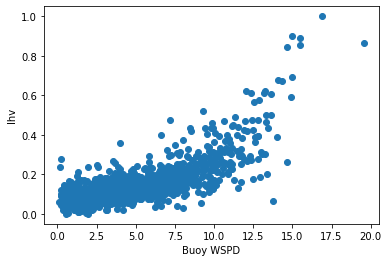

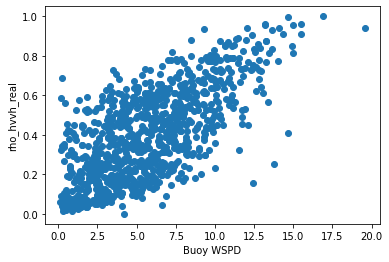


 ***** neural network *****
Fold #1
Fold #2
Fold #3
Fold #4
Fold #5
Fold #6
Fold #7
Fold #8
Fold #9
Fold #10
Fold #11
Fold #12
Fold #13
Fold #14
Fold #15


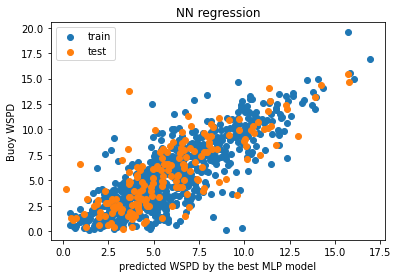


 
Best fold number: 15
Best model rmse: 2.107
Best model r2: 0.625
Best model cc: 0.798
Best model mae: 1.584
statistics


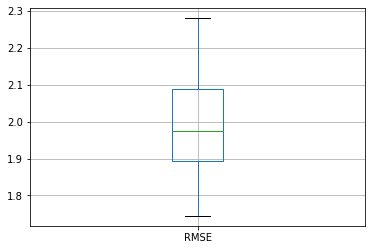

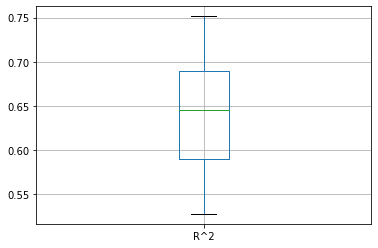

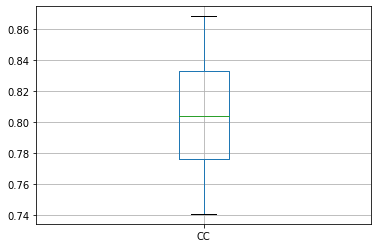

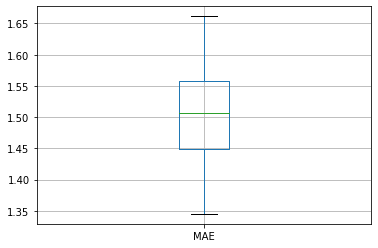


 ***** random forest *****

 Fold #1

 Fold #2

 Fold #3

 Fold #4

 Fold #5

 Fold #6

 Fold #7

 Fold #8

 Fold #9

 Fold #10

 Fold #11

 Fold #12

 Fold #13

 Fold #14

 Fold #15


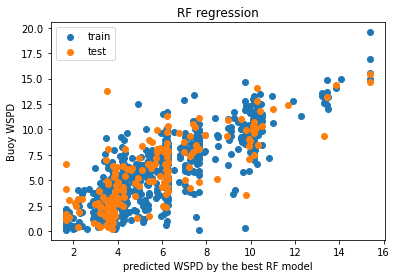


 
Best fold number: 15
Best model rmse: 2.095
Best model r2: 0.630
Best model cc: 0.794
Best model mae: 1.597
Best model parameters: {'bootstrap': True, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 149}
statistics


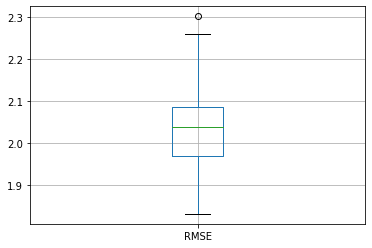

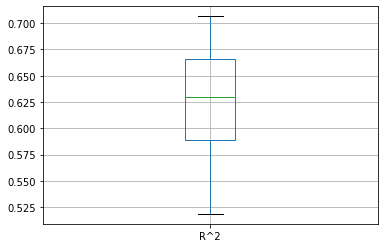

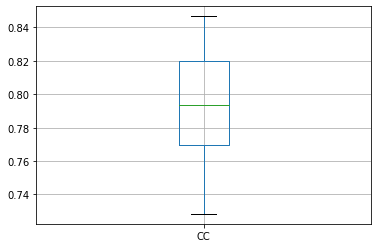

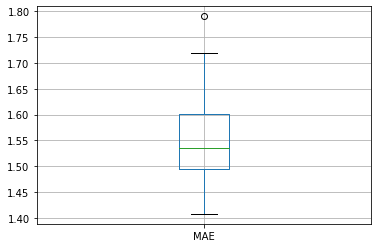

In [ ]:
##------------------------------------------------------------------------------
## inputs' and outputs' directories
##------------------------------------------------------------------------------
## inputs' and outputs' directories
## without smoothing filters
# outputs_address = '/content/drive/My Drive/Colab Notebooks/Wind_estimation/outputs.mat'
# inputs_address = '/content/drive/My Drive/Colab Notebooks/Wind_estimation/inputs.mat'

## with smoothdate filter and window size of 31
# inputs_address = '/content/drive/My Drive/Colab Notebooks/inputs_smoothdata_WS31.mat'
# outputs_address = '/content/drive/My Drive/Colab Notebooks/outputs_smoothdata_WS31.mat'

# ## with Box car filter and window size of 31
# inputs_address = '/content/drive/My Drive/Colab Notebooks/inputs_BoxCar_WS31.mat'
# outputs_address = '/content/drive/My Drive/Colab Notebooks/outputs_BoxCar_WS31.mat'

# ##ts_address = '/content/drive with Box car filter and window size of 11
# inputs_address = '/content/drive/My Drive/Colab Notebooks/inputs_BoxCar_WS11.mat'
# outpu/My Drive/Colab Notebooks/outputs_BoxCar_WS11.mat'

## filtered by Box car with window size 31, input with Doppler centroid
inputs_address = '/content/drive/My Drive/Colab Notebooks/Wind_estimation/inputs_Box car_31_with_Dca.mat'
outputs_address = '/content/drive/My Drive/Colab Notebooks/Wind_estimation/outputs_Box car_31_with_Dca.mat'


##------------------------------------------------------------------------------
## import inputs and outputs
##------------------------------------------------------------------------------
inputs, outputs = import_data(inputs_address, outputs_address)


# del inputs['name']
# del inputs['incidence_angle']
invalids = ('name', 'hh', 'hv', 'vh', 'vv', 'rho_hvhh_real', 'rho_hvhh_imag', \
           'rho_vhhh_real', 'rho_vhhh_imag', 'rho_vvhh_real', \
           'rho_vvhh_imag', 'rho_vhhv_real', 'rho_vhhv_imag', 'rho_vvhv_real', \
           'rho_vvhv_imag', 'rho_vvvh_real', 'rho_vvvh_imag')
for key in invalids:
    if key in inputs:
        del inputs[key]
del outputs['name']

## return the real part of the complex values of inputs
inputs = inputs.apply(lambda x: np.real(x))

wspd_estimation = 1

##------------------------------------------------------------------------------
## remove invalid data with negative values of wind speed
##------------------------------------------------------------------------------
outputs['wspd_10ht'] = pd.to_numeric(outputs['wspd_10ht'])
outputs = outputs.drop(labels=194, axis=0)
inputs = inputs.drop(labels=194, axis=0)
# print(outputs.loc[[194]])
invalid_indexes = outputs.loc[outputs['wspd_10ht'] < 0]
if invalid_indexes['wspd_10ht'].any:
  inputs.drop(invalid_indexes['wspd_10ht'], inplace=True)
  outputs.drop(invalid_indexes['wspd_10ht'], inplace=True)
## or using this piece of code to remove invalid data with negative values of wind speed
# invalid_indexes = outputs['wspd_10ht'] < 0
# inputs.drop(outputs[invalid_indexes].index, inplace=True)
# outputs.drop(outputs[invalid_indexes].index, inplace=True)

first_inputs = inputs.copy()
del inputs['incidence_angle']
first_outputs = outputs.copy()
if wspd_estimation == 1:
  del outputs['relative_wdir']


##------------------------------------------------------------------------------
## initialization
##------------------------------------------------------------------------------
normalization = 1
## "normalization": (min_max_normalization, (0, 1)) or
## "standardization": (mean_normalization)
scaling_method = "normalization"
selection = 1 # feature selection


##------------------------------------------------------------------------------
## scale predictor variables
##------------------------------------------------------------------------------
if normalization == 1:
  inputs_scaled = predictor_scaling(inputs, scaling_method)
else:
  inputs_scaled = inputs.copy()


##------------------------------------------------------------------------------
## select predictor variables
##------------------------------------------------------------------------------
if selection == 1:
  # ## correlation coefficient between the relative wind direction and
  # ## Radarsat-2 polarimetric features
  corre_coefs = []
  corrs = []
  for field in inputs_scaled.keys():
    corre_coef = np.corrcoef(np.transpose(inputs_scaled[field]).astype(float), \
            np.transpose(outputs.values).astype(float))
    corre_coefs.append([corre_coef[0, 1]])
    corrs.append([field, corre_coef[0, 1]])
  print('correlation coefficient between the wind speeds and '
        'Radarsat-2 polarimetric features: ')
  print(corrs)

  inputs_selected = predictor_selection(inputs_scaled, outputs, \
                    alpha=0.1, selection_criteria=0.1, model_name='Lasso')
else:
  inputs_selected = inputs_scaled.copy()

# ## plot wind speed vs selected predictor variables
# for key in selected_inputs.keys():
#   plt.scatter(selected_inputs[key], outputs_normalized, color="blue")
#   plt.xlabel(key)
#   plt.ylabel("wind speed")
#   plt.show()


##------------------------------------------------------------------------------
## predict wind speed with regression models
##------------------------------------------------------------------------------
##------------------------------------------------------------------------------
## neural network multi-layer Perceptron (NN-MLP) regressor
"""
based on sklearn documentation on https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

activation: {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
Activation function for the hidden layer.
‘identity’, no-op activation, useful to implement linear bottleneck, returns f(x) = x
‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x).
‘relu’, the rectified linear unit function, returns f(x) = max(0, x)

solver: {‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’
The solver for weight optimization.
‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
‘sgd’ refers to stochastic gradient descent.
‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
Note: The default solver ‘adam’ works pretty well on relatively
large datasets (with thousands of training samples or more) in terms of
both training time and validation score. For small datasets, however,
‘lbfgs’ can converge faster and perform better.

alpha: float, default=0.0001
L2 penalty (regularization term) parameter.

batch_size: int, default=’auto’
Size of minibatches for stochastic optimizers. If the solver is ‘lbfgs’,
the classifier will not use minibatch.
When set to “auto”, batch_size=min(200, n_samples)
"""

"""
based on tensorflow.keras.optimizers documentation on https://www.tensorflow.org/api_docs/python/tf/keras/optimizers


optimizer=solver: {'Adadelta', 'Adagrad', 'Adam', 'Adamax', 'Ftrl', \
'Nadam', 'Optimizer', 'RMSprop', 'SGD'}

# """
# output_predict_mlp = \
mlp_regression(inputs_selected, outputs, activation='relu', \
              solver='adam', max_iter=500, k_fold=5)


##----------------------------------------------------------------------------
## Random forests regression
output_predict_rf = random_forest_regression(inputs_selected, \
                    outputs, k_fold=5)



from scipy.io import savemat
# drive.mount('/content/drive')
# filename_pred_mlp = "/content/drive/My Drive/Colab Notebooks/Wind_estimation/WSPD_predicted_mlp_" + str(year) + ".mat"
# output_predict_dict = {"output_predict_mlp": output_predict_mlp, "output_predict_rf": output_predict_rf}
# filename_pred_mlp = "/content/drive/My Drive/Colab Notebooks/Wind_estimation/WSPD/WSPD_predicted.mat"
# savemat(filename_pred_mlp, output_predict_dict)

WSPD_in_outputs_dict = {"vh": np.array(inputs['Ivh']), \
                        "hv": np.array(inputs['Ihv']), \
                        "rho_hvvh_real": np.array(inputs['rho_hvvh_real']), \
                        "t": np.array(first_inputs['incidence_angle']), \
                        "s": np.array(outputs['wspd_10ht']), \
                        "d": np.array(first_outputs['relative_wdir']), \
                        "output_predict_mlp": output_predict_mlp, \
                        "output_predict_rf": output_predict_rf}

filename_inputs = "/content/drive/My Drive/Colab Notebooks/Wind_estimation/WSPD/WSPD_in_outputs.mat"
savemat(filename_inputs, WSPD_in_outputs_dict)

In [ ]:
inputs_address = '/content/drive/My Drive/Colab Notebooks/Wind_estimation/inputs_Box car_31_with_Dca.mat'
outputs_address = '/content/drive/My Drive/Colab Notebooks/Wind_estimation/outputs_Box car_31_with_Dca.mat'

##------------------------------------------------------------------------------
## import inputs and outputs
##------------------------------------------------------------------------------
inputs, outputs = import_data(inputs_address, outputs_address)

# print(np.array(inputs['vh']))

WSPD_in_outputs_dict = {"rho_vvvh_imag": np.array(inputs['rho_vvvh_imag']), \
                        "rho_vvvh_real": np.array(inputs['rho_vvvh_real'])}
                        # "vh": np.array(inputs['vh']), \
                        # "vv": np.array(inputs['vv'])}
                        # "rho_hvvh_real": np.array(inputs['rho_hvvh_real']), \
                        # "t": np.array(inputs['incidence_angle']), \
                        # "s": np.array(outputs['wspd_10ht']), \
                        # "d": np.array(outputs['relative_wdir'])}
from scipy.io import savemat
filename_inputs = "/content/drive/My Drive/Colab Notebooks/Wind_estimation/rho_vvvh_inputs.mat"
savemat(filename_inputs, WSPD_in_outputs_dict)
# filename_outputs = "/content/drive/My Drive/Colab Notebooks/Wind_estimation/WSPD_outputs.mat"
# savemat(filename_outputs, outputs.to_dict())
# print(inputs.to_dict())
# print(np.shape(inputs))
# print(np.shape(outputs))
# print(outputs)

In [ ]:

output_predict_dict = {"output_predict_mlp": output_predict_mlp, "output_predict_rf": output_predict_rf}

from scipy.io import savemat
# drive.mount('/content/drive')
# filename_pred_mlp = "/content/drive/My Drive/Colab Notebooks/Wind_estimation/WSPD_predicted_mlp_" + str(year) + ".mat"
filename_pred_mlp = "/content/drive/My Drive/Colab Notebooks/Wind_estimation/WSPD_predicted.mat"
# filename_pred_rf = "/content/drive/My Drive/Colab Notebooks/Wind_estimation/WSPD_predicted_rf_.mat"
savemat(filename_pred_mlp, output_predict_dict)
# savemat(filename_pred_rf, output_predict_rf_dict)



<class 'numpy.ndarray'>
